In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/

Mounted at /content/drive
/content/drive/MyDrive/Github


In [5]:
!git clone https://<<your_github_token>>@github.com/<<your_github_username>>/questions-with-SQL

Cloning into 'questions-with-SQL'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 29 (delta 9), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (29/29), 724.79 KiB | 5.89 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [7]:
%cd questions-with-SQL

/content/drive/MyDrive/Github/questions-with-SQL


# Answering Business Questions Using SQL

In this guided project by Dataquest (DQ), I used SQL to answer business questions using information about a fictional digital music shop. The Chinook database contains information about the artists, songs, and albums from the music shop, as well as data on the shop's employees, customers, and the customers' purchases.

The goal is to find answers and provide recommendations on the following:

* Which music genres sell the most tracks in the USA?
* What is the sales performance of the shop's employees?
* Which countries have the potential for growth?
* What percentage of purchases are whole albums versus individual tracks?
* Which artist is used in most playlists?
* How many tracks have been purchased versus not purchased?
* Is the range of tracks in the store reflective of their sales popularity?
* Do protected versus non-protected media types affect sales popularity?

## Creating Helper Functions

Use the helper functions

`run_query()` to quickly read SQL queries into DataFrames


`show_tables()` to return a list of all tables and views of the Chinook database, respectively.

In [8]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def show_tables():
    q = '''
    SELECT
        name

    FROM sqlite_master
    WHERE type in ("table", "view");
    '''
    return run_query(q)

show_tables()

,name
0,album
1,artist
2,customer
3,employee
4,genre
5,invoice
6,invoice_line
7,media_type
8,playlist
9,playlist_track


The Chinook database contains 11 tables of data.  The tables are related according to the database schema shown below.

![Chinook Schema](https://github.com/orcascope/questions-with-SQL/blob/master/chinook-schema.jpg?raw=1)

1. Top 3 customer states in terms of  invoice total.
2. Get just the Top 5th (not top 5) customer state in terms of number of distinct customers.
3. Find the top Selling Music Genres in the USA

## Analyzing Employee Sales Performance
1. Find the total_sales made by each employee. Print a report of emp_name, hire_date, country and total sales.

## Analyzing Sales by Country
Find total sales and total count of customers by country. Also find average sales by customer and average order value in each country.

Average sales by customer is Total Sales/Total num of customers
Average order value is Total Sales/Total num of invoices.

In [30]:
# q3= '''
# '''

# run_query(q3)

## Purchases of Whole Albums Versus Individual Tracks
1. Find all the albums purchased in each of the invoice. (Customer purchased tracks, but the track belong to an album)

2. Find the count of albums which were purchased in full. i.e all tracks were purchased in the same sale invoice, rather than just 1 or 2 tracks,

In [36]:
#

## Artist Mostly Used in Playlists
1. Which artist is more popular in the playlists ?
i.e Playlists are collection of tracks that were performed by Artists. Find which artist's tracks dominate the playlists


In [ ]:
#

,Artist,Tracks_Playlist,Percent_tracks
0,Iron Maiden,516,5.92
1,U2,333,3.82
2,Metallica,296,3.40
3,Led Zeppelin,252,2.89
4,Deep Purple,226,2.59
5,Lost,184,2.11
6,Pearl Jam,177,2.03
7,Eric Clapton,145,1.66
8,Faith No More,145,1.66
9,Lenny Kravitz,143,1.64


## Purchased versus Unpurchased Tracks
1. Of the total tracks present in the albums,how many were purchased atleast once, and how many were never purchased.

In [37]:
#

## Availability of Tracks and Sales Popularity

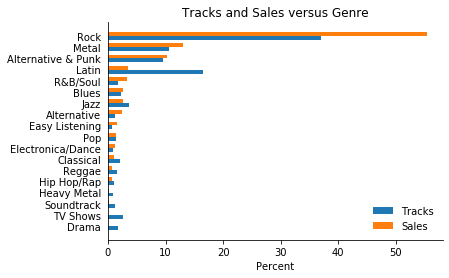

In [ ]:
q8 = '''

WITH genre_sales AS
    (
    SELECT
        g.name Genre,
        TOTAL(il.unit_price) Sales
    FROM invoice_line il
    LEFT JOIN track t ON t.track_id = il.track_id
    LEFT JOIN genre g ON g.genre_id = t.genre_id
    GROUP BY 1
    )

SELECT
    g.name Genre,
    COUNT(DISTINCT t.track_id) Tracks,
    100*CAST(COUNT(DISTINCT t.track_id) AS FLOAT) / CAST((SELECT COUNT(DISTINCT track_id) FROM track) AS FLOAT) Percent_tracks,
    gs.Sales,
    100*gs.Sales / (SELECT TOTAL(total) FROM invoice) Percent_sales
FROM genre g
INNER JOIN track t ON t.genre_id = g.genre_id
INNER JOIN genre_sales gs ON gs.Genre = g.name
GROUP BY 1
ORDER BY 4 ASC

'''

df2 = run_query(q8)

genre_tracks_sales = df2[['Genre', 'Percent_tracks', 'Percent_sales']].copy()

y = np.arange(len(genre_tracks_sales['Genre']))
width = 0.35

plt.barh(y - width/2, genre_tracks_sales['Percent_tracks'], width, label='Tracks')
plt.barh(y + width/2, genre_tracks_sales['Percent_sales'], width, label='Sales')

plt.xlabel('Percent')
plt.title('Tracks and Sales versus Genre')
plt.yticks(y, genre_tracks_sales['Genre'])
plt.legend(frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(left=False)

plt.savefig('track_sales.jpg')
plt.show()


The range of tracks in the store mostly reflects the popularity of sales. I recommend adjusting the number of available tracks under `Latin`, `R&B/Soul`, `Blues`, and `Jazz`  genres to match the observed trends in sales.

## Media Type on Sales Popularity

In [ ]:
q9 = '''

SELECT
    Media_type,
    TOTAL(unit_price) Total_sales,
    ROUND(100*TOTAL(unit_price) / (SELECT TOTAL(unit_price) FROM invoice_line), 1) Percent_total_sales
FROM (
    SELECT
        il.invoice_line_id,
        il.invoice_id,
        il.track_id,
        il.unit_price,
        mt.name,
        CASE
            WHEN mt.name = (SELECT name FROM media_type WHERE name LIKE "%Protected%") THEN "Protected"
            ELSE "Non-protected"
            END
        AS Media_type
    FROM invoice_line il
    LEFT JOIN track t ON t.track_id = il.track_id
    INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id
    )
GROUP BY 1

'''
run_query(q9)

,Media_type,Total_sales,Percent_total_sales
0,Non-protected,4274.82,90.8
1,Protected,434.61,9.2


Tracks under non-protected media types account for 90% of the total sales.

## Conclusion

I conclude the following from my analysis of the Chinook database:

* `Rock`,  `Alternative & Punk`, `Metal`, and `R&B/Soul` are among the top-selling music genres in the USA. The addition of new albums and tracks from American artists under these genres could improve the sales performance of the store.
* I determined the sales performance of the shop's employees. The sales performance of employees seems to depend on their hiring dates.
* Czech Republic, United Kingdom, and India show opportunities for growth due to high average values of sales (dollars per customer) and above-average order values (dollars per invoice).
* About 20% of total sales come from whole album purchases. The store should continue to selling individual tracks and whole albums.
* The artist `Iron Maiden` is mostly used in the playlists.
* About half of the available tracks in the store remain unpurchased.
* The range of tracks in the store mostly reflects the sales performance. I suggest revising the number of tracks classified under `Latin`, `R&B/Soul`, `Blues`, and `Jazz` genres following the observed trends in sales.
* Tracks categorized under non-protected media types significantly sell better than protected types.